In [1]:
import numpy as np
import xgboost as xgb

from wvz_helpers import load_dataframes, load_dataframe, skims

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import os

## Do the 2D significance scan

In [5]:
import pandas as pd

In [6]:

def L(s, b):
    return np.sqrt(2.0 * ((s + b) * np.log(1 + s / b) - s))

In [7]:


def estimate_l(df_sig, df_bkg, cuts, variable):
    
    cuts = np.concatenate([[-np.inf], cuts, [np.inf]])
    cuts = np.sort(cuts)
    
    df_sig_bins = pd.DataFrame(dict(bin=pd.cut(df_sig[variable], cuts, labels=False, duplicates='drop'),
                                    weight=df_sig["weight"]))
    df_bkg_bins = pd.DataFrame(dict(bin=pd.cut(df_bkg[variable], cuts, labels=False, duplicates='drop'),
                                    weight=df_bkg["weight"]))    
    
    
    sig_sums = df_sig_bins.groupby("bin")["weight"].sum()
    bkg_sums = df_bkg_bins.groupby("bin")["weight"].sum()
    
    ls = []
    for i in sig_sums.index.values:
        bkg_sum = bkg_sums[i] if i in bkg_sums.index else 0.0
        ls.append(L(sig_sums[i], bkg_sum))
        
    return np.sum(np.array(ls)**2) ** 0.5

## Tune for only nonh as signal

In [13]:
backgrounds = [
    "zz",
    "ttz",
    "twz",
    "wz",
    "higgs",
    "othernoh",
    #"nonh_wwz",
    #"nonh_wzz",
    #"nonh_zzz",
    "zh_wwz",
    "wh_wzz",
    "zh_zzz",
]

signals = [
    "nonh_wwz",
    "nonh_wzz",
    "nonh_zzz",
    #"zh_wwz",
    #"wh_wzz",
    #"zh_zzz",
]

data_background = load_dataframes(backgrounds, concat=True, exclude_training=True)
data_signal = load_dataframes(signals, concat=True, exclude_training=True)

data_background["is_signal"] = False
data_signal["is_signal"] = True

data = pd.concat([data_signal, data_background], ignore_index=True)
data = data.query("is_ChannelEMu").copy()

X = data[["bdt_OffZ_wwz_vs_zz"]].values

y = data.eval("is_signal == 1").values
w = data["weight"].values

data.query("is_signal == 1")["weight"].sum()

data.query("is_signal == 0")["weight"].sum()


df_sig = data.query(f"is_signal == 1")
df_bkg = data.query(f"is_signal == 0")

<ipython-input-6-9e768c1d7f95>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(2.0 * ((s + b) * np.log(1 + s / b) - s))
<ipython-input-6-9e768c1d7f95>:2: RuntimeWarning: invalid value encountered in log
  return np.sqrt(2.0 * ((s + b) * np.log(1 + s / b) - s))


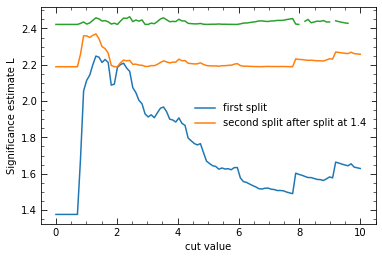

In [14]:
cut_range = np.linspace(0, 10, 100)
l_range = np.zeros_like(cut_range)

score = "EMu_score_nonh"
#score = "EMu_score"
#score = "EMu_score_vh"

for i, cut in enumerate(cut_range):
    l_range[i] = estimate_l(df_sig, df_bkg, [cut], score)

plt.plot(cut_range, l_range, label="first split")
plt.xlabel("cut value")
plt.ylabel("Significance estimate L")



for i, cut in enumerate(cut_range):
    l_range[i] = estimate_l(df_sig, df_bkg, [cut, 2], score)

plt.plot(cut_range, l_range, label="second split after split at 1.4")
plt.legend()

for i, cut in enumerate(cut_range):
    l_range[i] = estimate_l(df_sig, df_bkg, [cut, 1, 2, 3.0, 8, 10], score)

plt.plot(cut_range, l_range, label="second split after split at 1.0, 1.4 and 3.0")

## Tune for both as signal

In [16]:
backgrounds = [
    "zz",
    "ttz",
    "twz",
    "wz",
    "higgs",
    "othernoh",
    #"nonh_wwz",
    #"nonh_wzz",
    #"nonh_zzz",
    #"zh_wwz",
    #"wh_wzz",
    #"zh_zzz",
]

signals = [
    "nonh_wwz",
    "nonh_wzz",
    "nonh_zzz",
    "zh_wwz",
    "wh_wzz",
    "zh_zzz",
]

data_background = load_dataframes(backgrounds, concat=True, exclude_training=True)
data_signal = load_dataframes(signals, concat=True, exclude_training=True)

data_background["is_signal"] = False
data_signal["is_signal"] = True

data = pd.concat([data_signal, data_background], ignore_index=True)
data = data.query("is_ChannelEMu").copy()

X = data[["bdt_OffZ_wwz_vs_zz"]].values

y = data.eval("is_signal == 1").values
w = data["weight"].values

data.query("is_signal == 1")["weight"].sum()

data.query("is_signal == 0")["weight"].sum()


df_sig = data.query(f"is_signal == 1")
df_bkg = data.query(f"is_signal == 0")

<ipython-input-6-9e768c1d7f95>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(2.0 * ((s + b) * np.log(1 + s / b) - s))


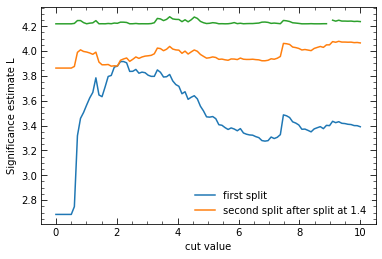

In [20]:
cut_range = np.linspace(0, 10, 100)
l_range = np.zeros_like(cut_range)

#score = "EMu_score_nonh"
score = "EMu_score"
#score = "EMu_score_vh"

for i, cut in enumerate(cut_range):
    l_range[i] = estimate_l(df_sig, df_bkg, [cut], score)

plt.plot(cut_range, l_range, label="first split")
plt.xlabel("cut value")
plt.ylabel("Significance estimate L")



for i, cut in enumerate(cut_range):
    l_range[i] = estimate_l(df_sig, df_bkg, [cut, 2], score)

plt.plot(cut_range, l_range, label="second split after split at 1.4")
plt.legend()

for i, cut in enumerate(cut_range):
    l_range[i] = estimate_l(df_sig, df_bkg, [cut, 1, 2, 3.0, 6, 9], score)

plt.plot(cut_range, l_range, label="second split after split at 1.0, 1.4 and 3.0")